In [1]:
from fiotools import ClatGrid
from pathlib2 import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [160]:
def clatgrid_helper(scenario, rw_modes = ['read', 'randread', 'write', 'randwrite'],
                    n_clients = [1, 64], skip_bs=[2**7, 2**8, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13],
                    logscale=False, ylim_bw=[0, 7000], ylim_cl=[1, 10**6], verbose=False):
    l_clients = len(n_clients)
    l_rw_modes = len(rw_modes)
    fig_bw, axes_bw = plt.subplots(l_clients, l_rw_modes, figsize=(30, l_clients*8))
    fig_cf, axes_cf = plt.subplots(l_clients, l_rw_modes, figsize=(30, l_clients*8))
    fig_cl, axes_cl = plt.subplots(l_clients, l_rw_modes, figsize=(30, l_clients*8))
    return_this = {}
    for i, clients in enumerate(n_clients):
        return_this[clients] = {}
        for j, rw in enumerate(rw_modes):
            input_dirs = list(Path('/opt/bharat/stackhpc-io-tools/kata-vs-crio/results/%s/beegfs-%s/%s' % (scenario, rw, clients)).iterdir())
            output_dir = Path('/opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/%s/beegfs-%s/%s' % (scenario, rw, clients))
            this = return_this[clients][rw] = ClatGrid(input_dirs, output_dir, granularity=200 if logscale else 2000, scenario=scenario, mode=rw, force=True, logscale=logscale, skip_bs=skip_bs, plot=False, verbose=verbose)
            this.plot_bw(fig=fig_bw, ax=axes_bw[i][j], ylim=ylim_bw)
            this.plot_cf(fig=fig_cf, ax=axes_cf[i][j], ylim=ylim_cl)
            this.plot_cl(fig=fig_cl, ax=axes_cl[i][j], ylim=ylim_cl)
            fig_bw.savefig('aggregate-bw-%s.png' % scenario)
            fig_cf.savefig('aggregate-cf-%s.png' % scenario)
            fig_cl.savefig('aggregate-cl-%s.png' % scenario)            
    return return_this

Deleting existing output data /opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/bare/beegfs-read/1/read-commit-latency.csv in output directory
Deleting existing output data /opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/bare/beegfs-read/1/read-bandwidth.csv in output directory
Deleting existing output data /opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/bare/beegfs-read/1/blocksize-vs-commit-latency.png in output directory
Deleting existing output data /opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/bare/beegfs-read/1/stacked-blocksize-vs-bandwidth.png in output directory
Deleting existing output data /opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/bare/beegfs-read/1/commit-latency-freq-dist.png in output directory
Deleting existing output data /opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/bare/beegfs-read/1/read-commit-latency-freq-dist.csv in output directory
Scanning for fio data in /opt/bharat/stackhpc-io-tools/kata-vs-cr

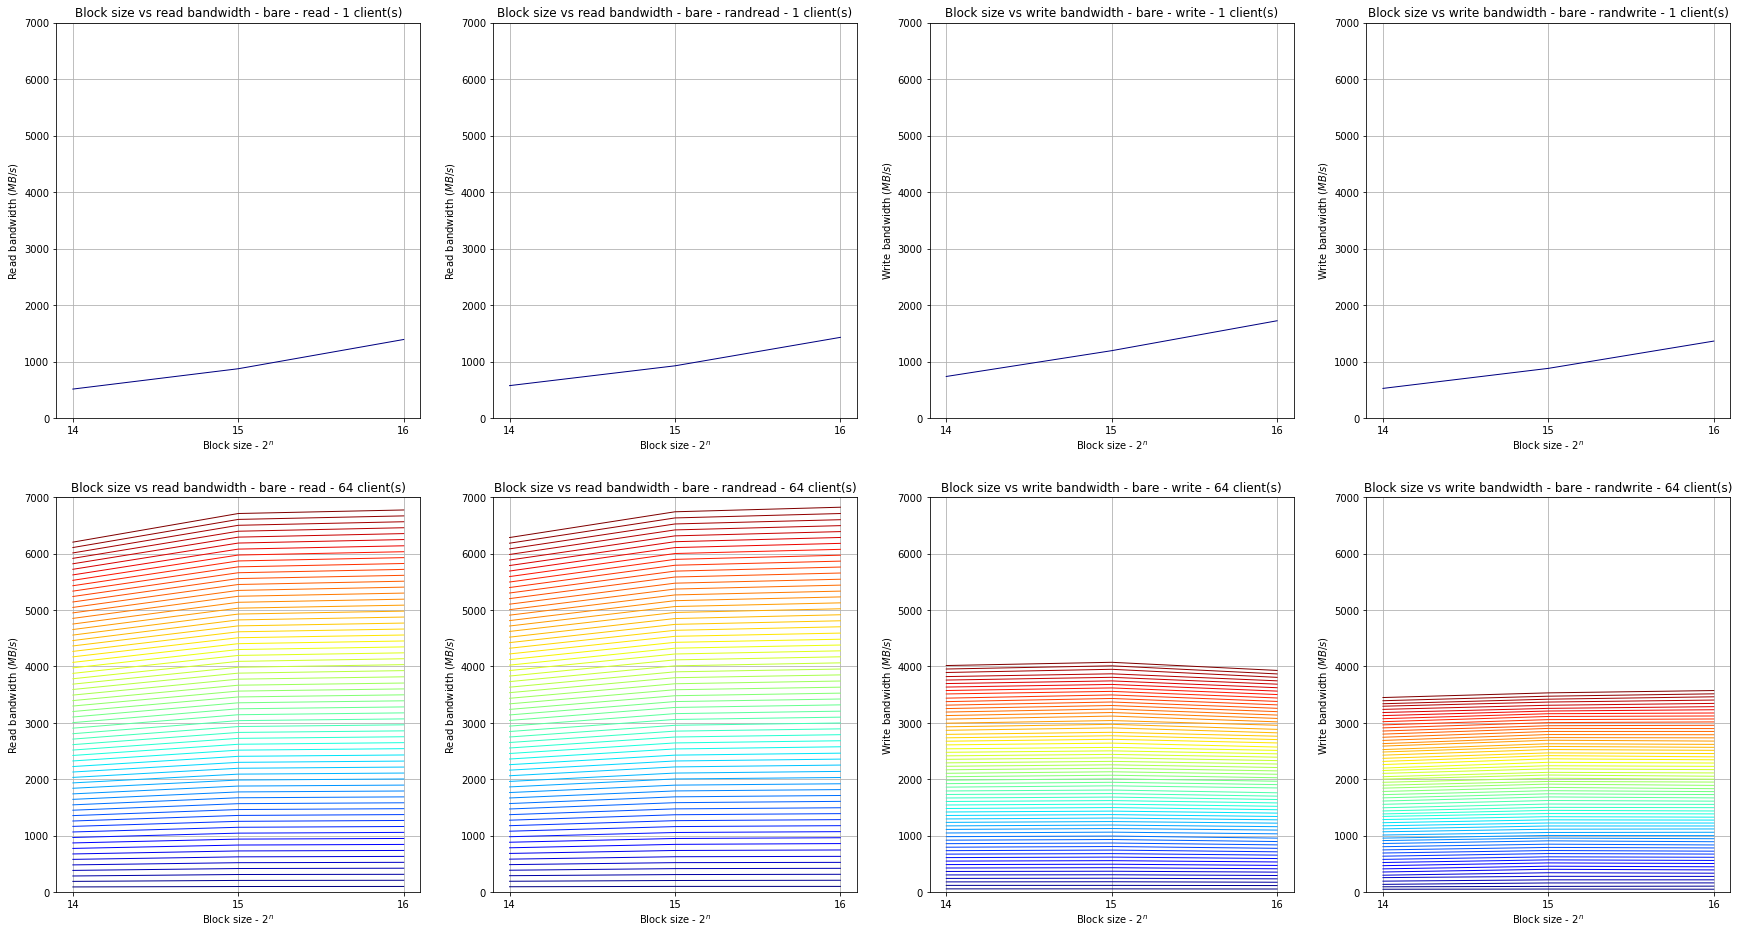

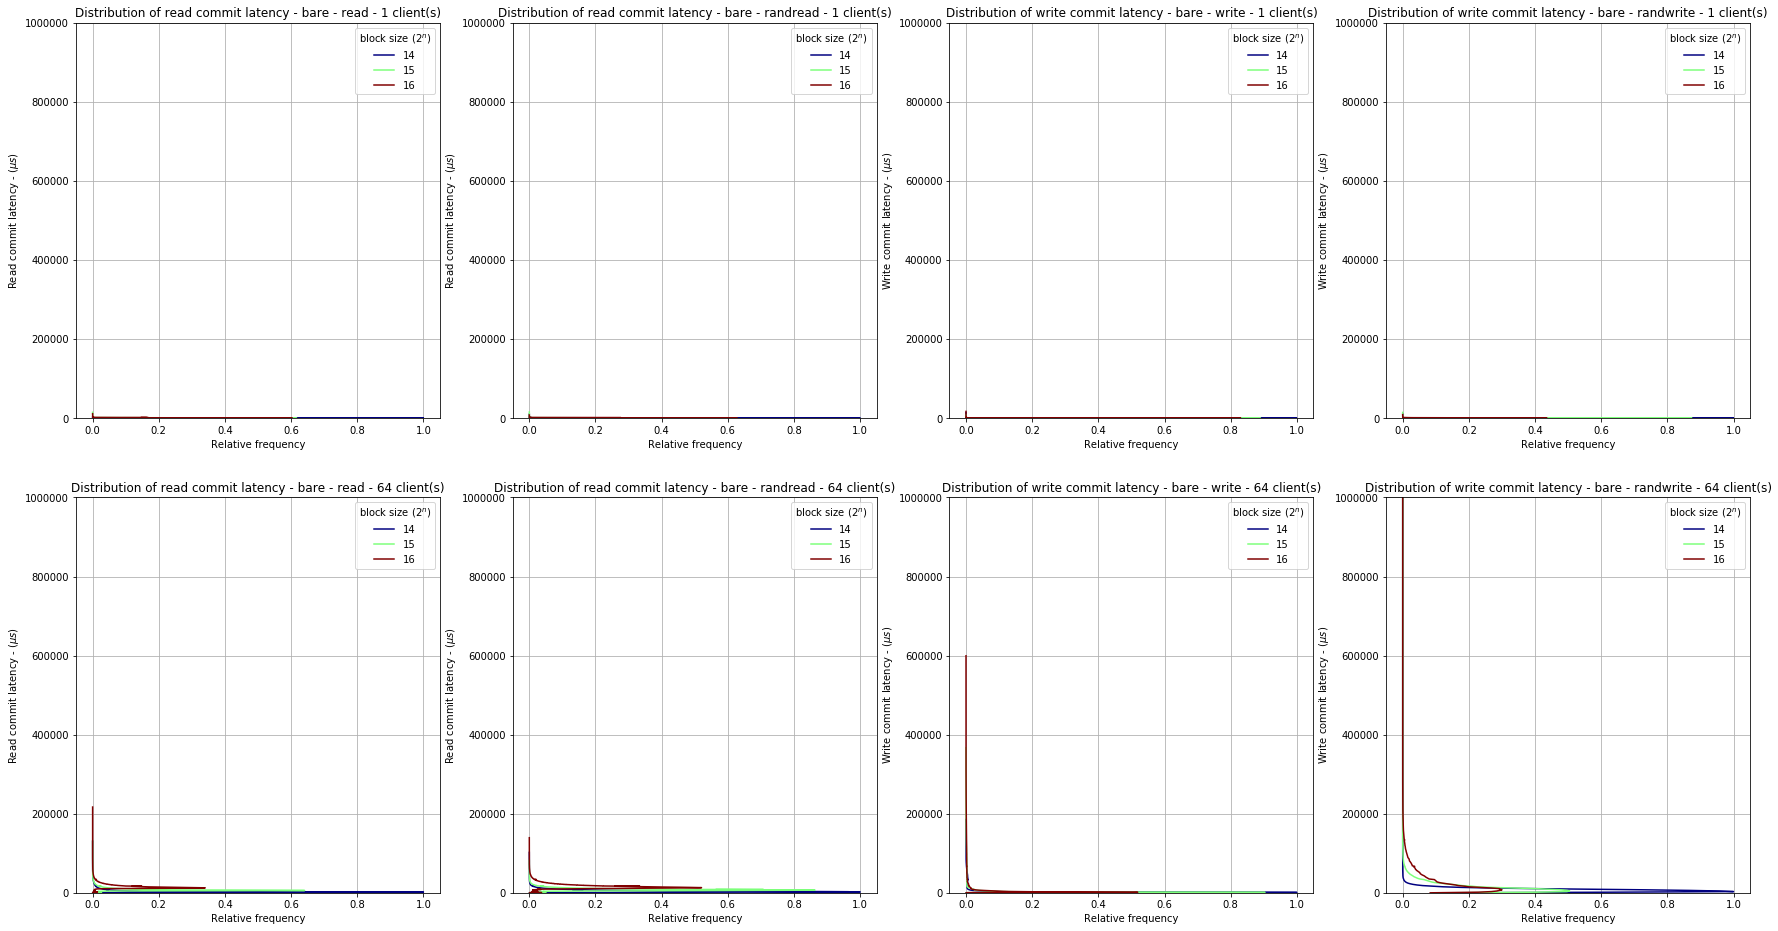

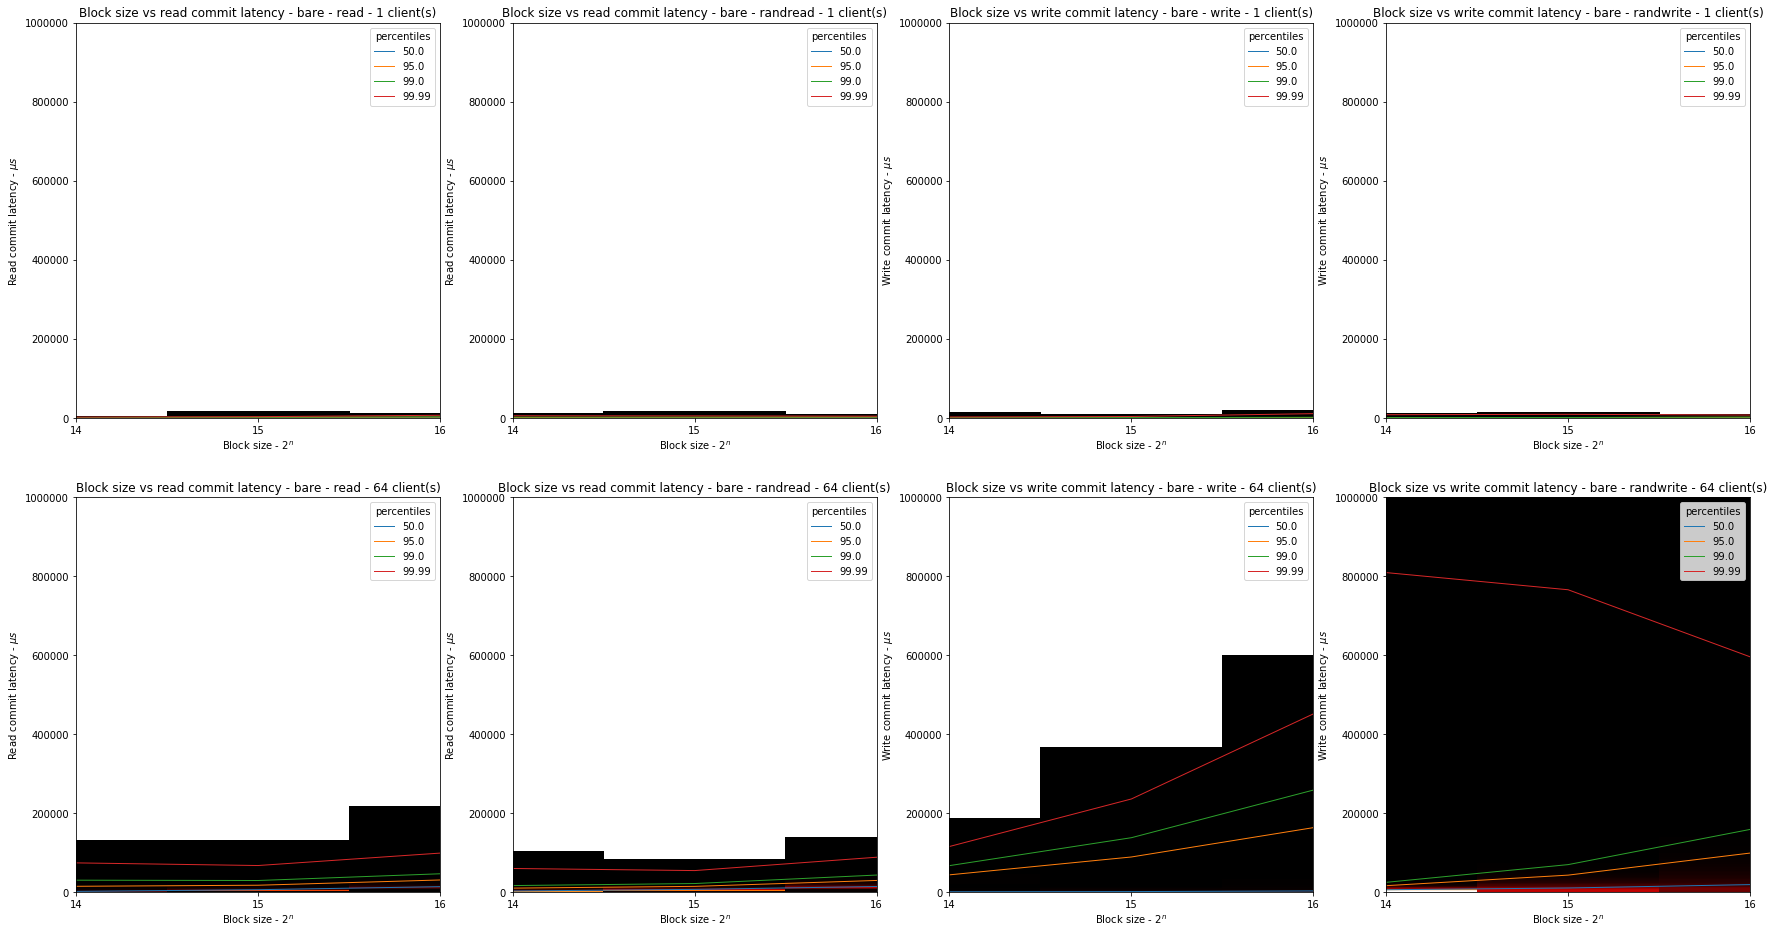

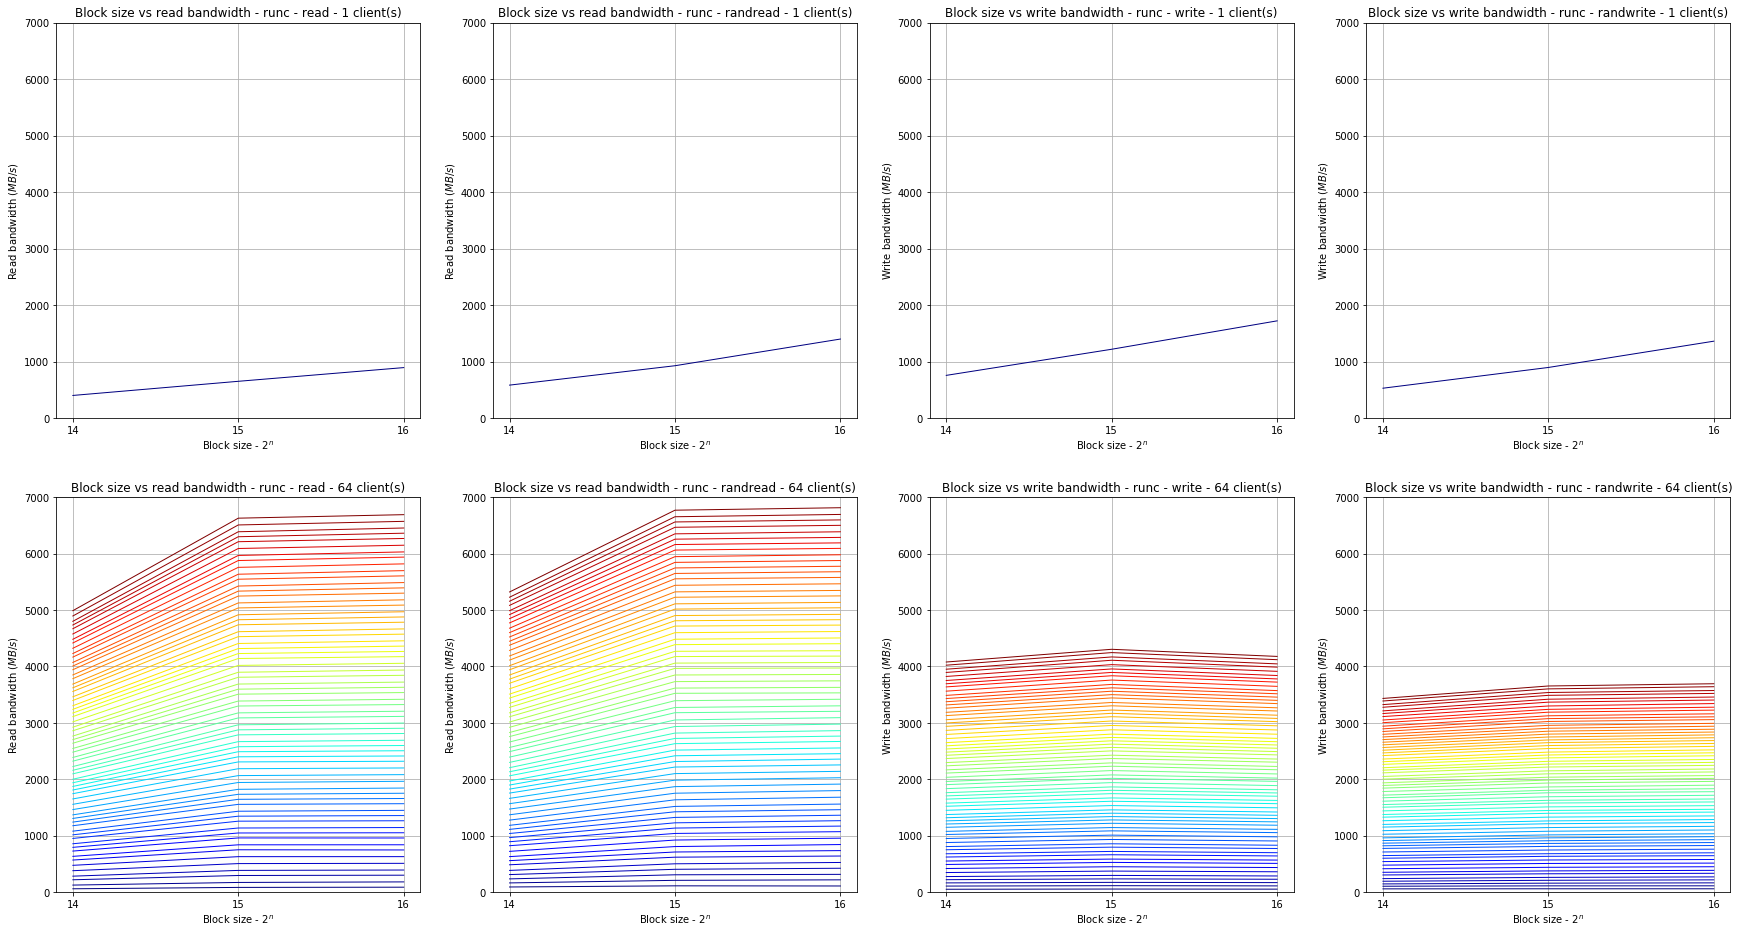

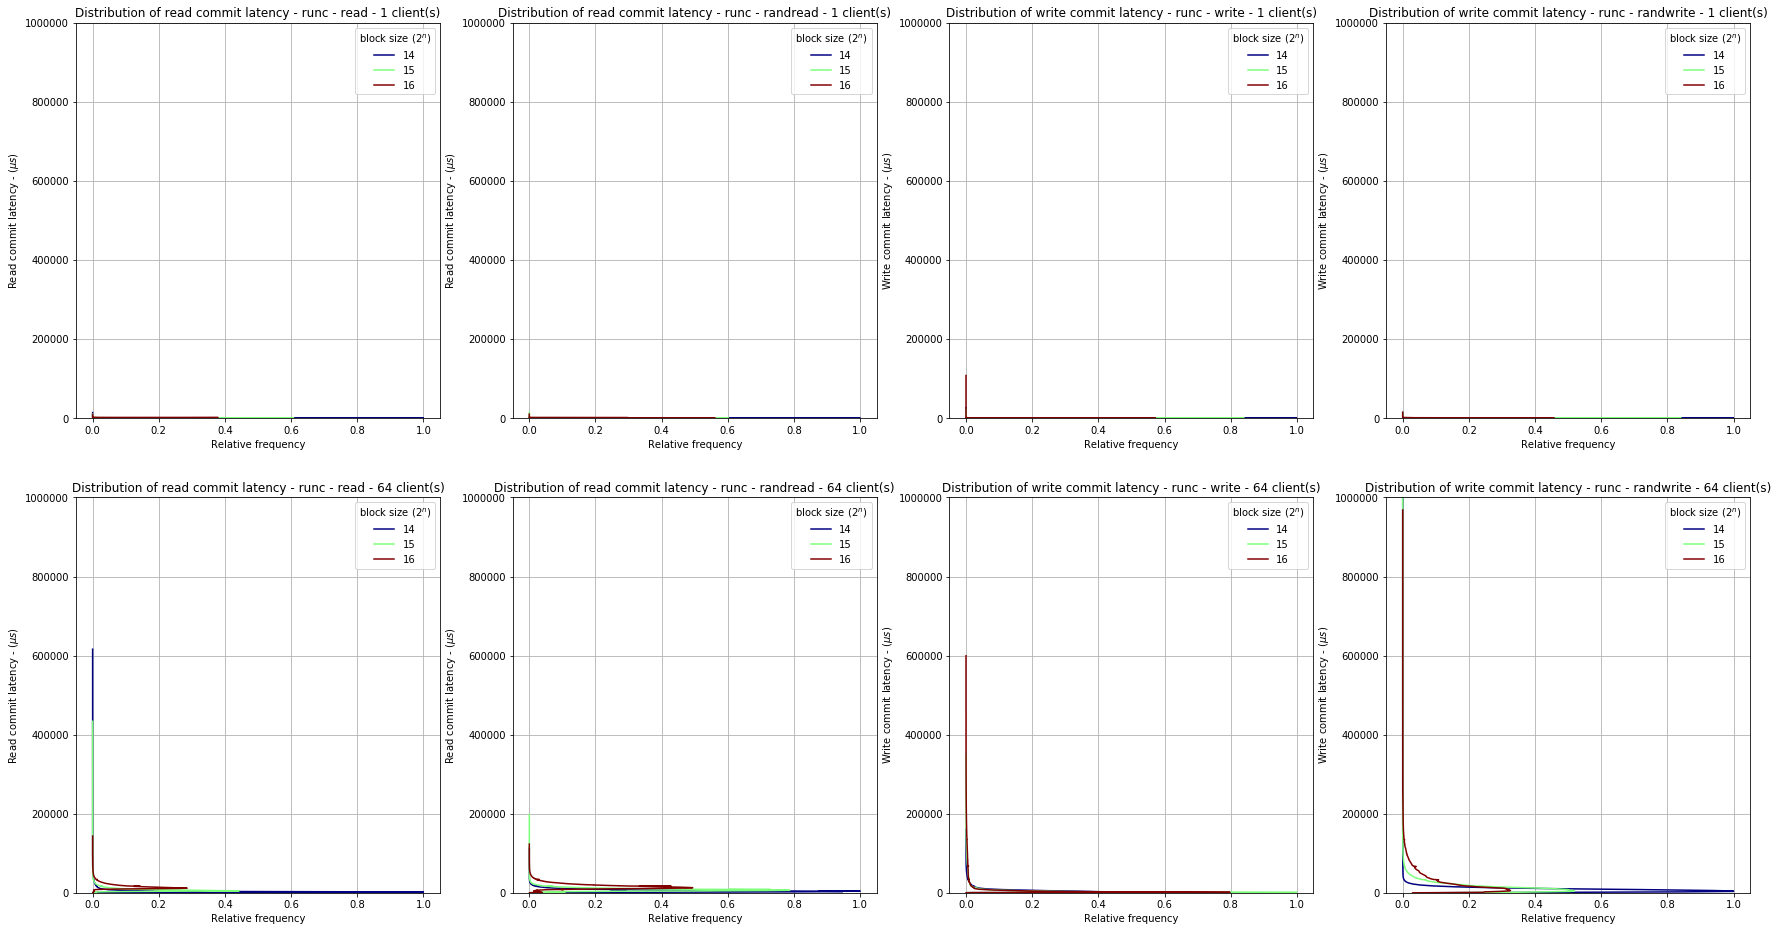

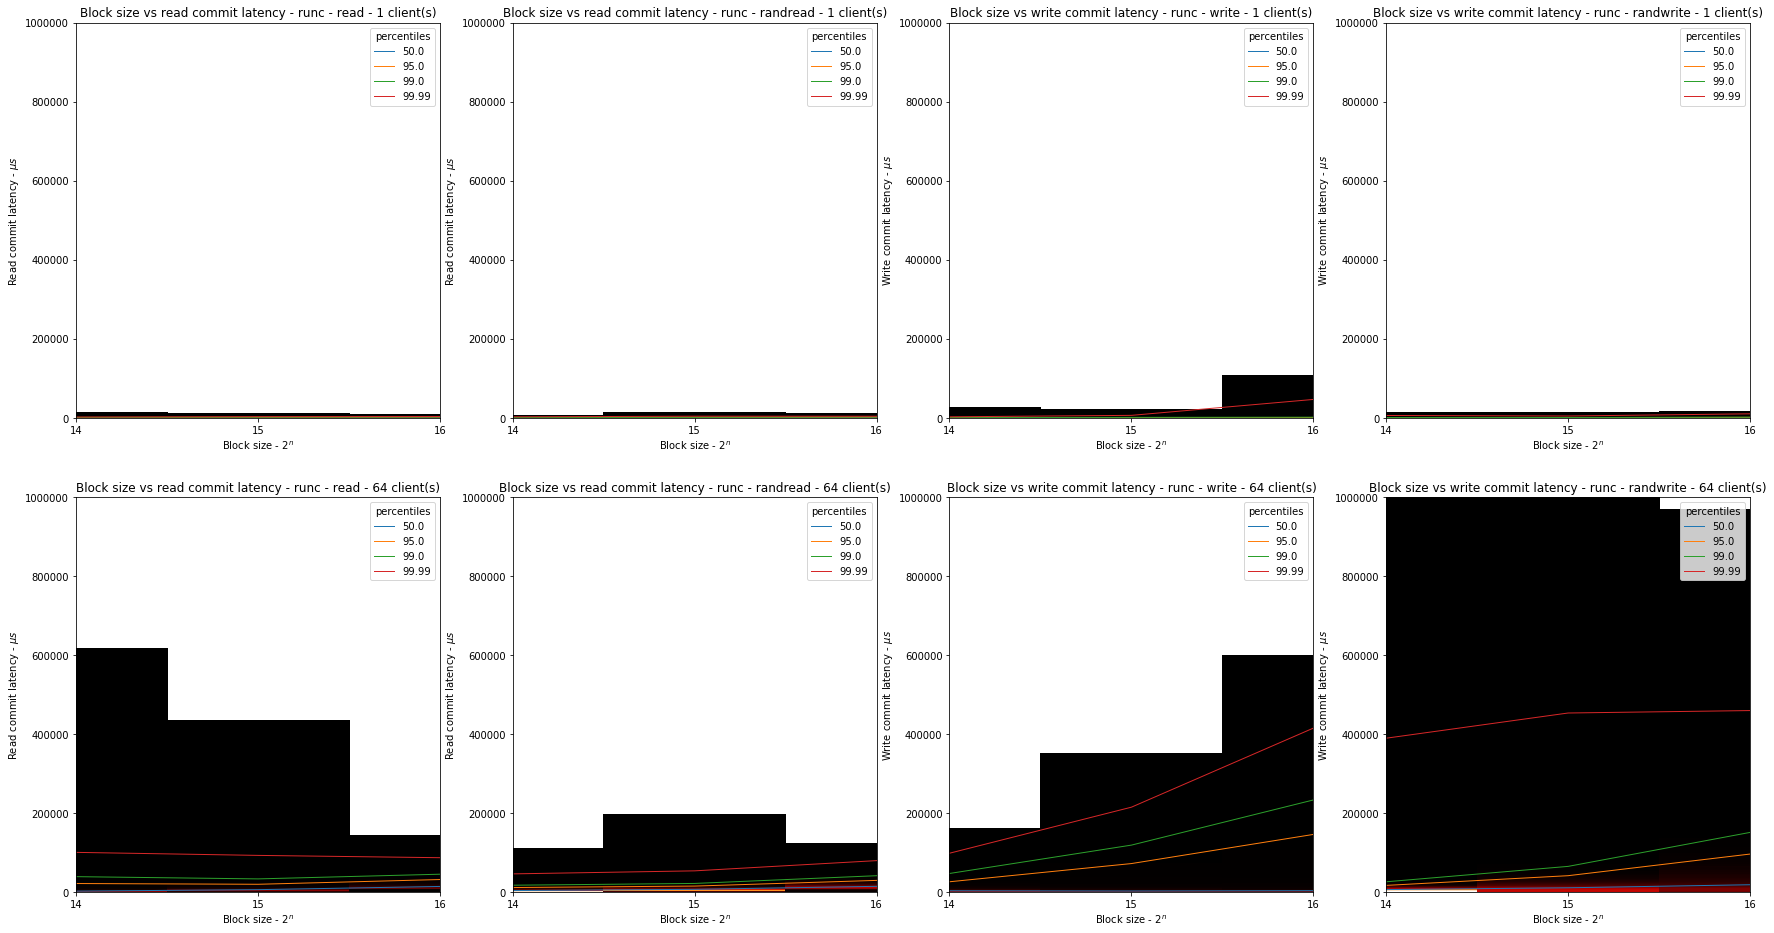

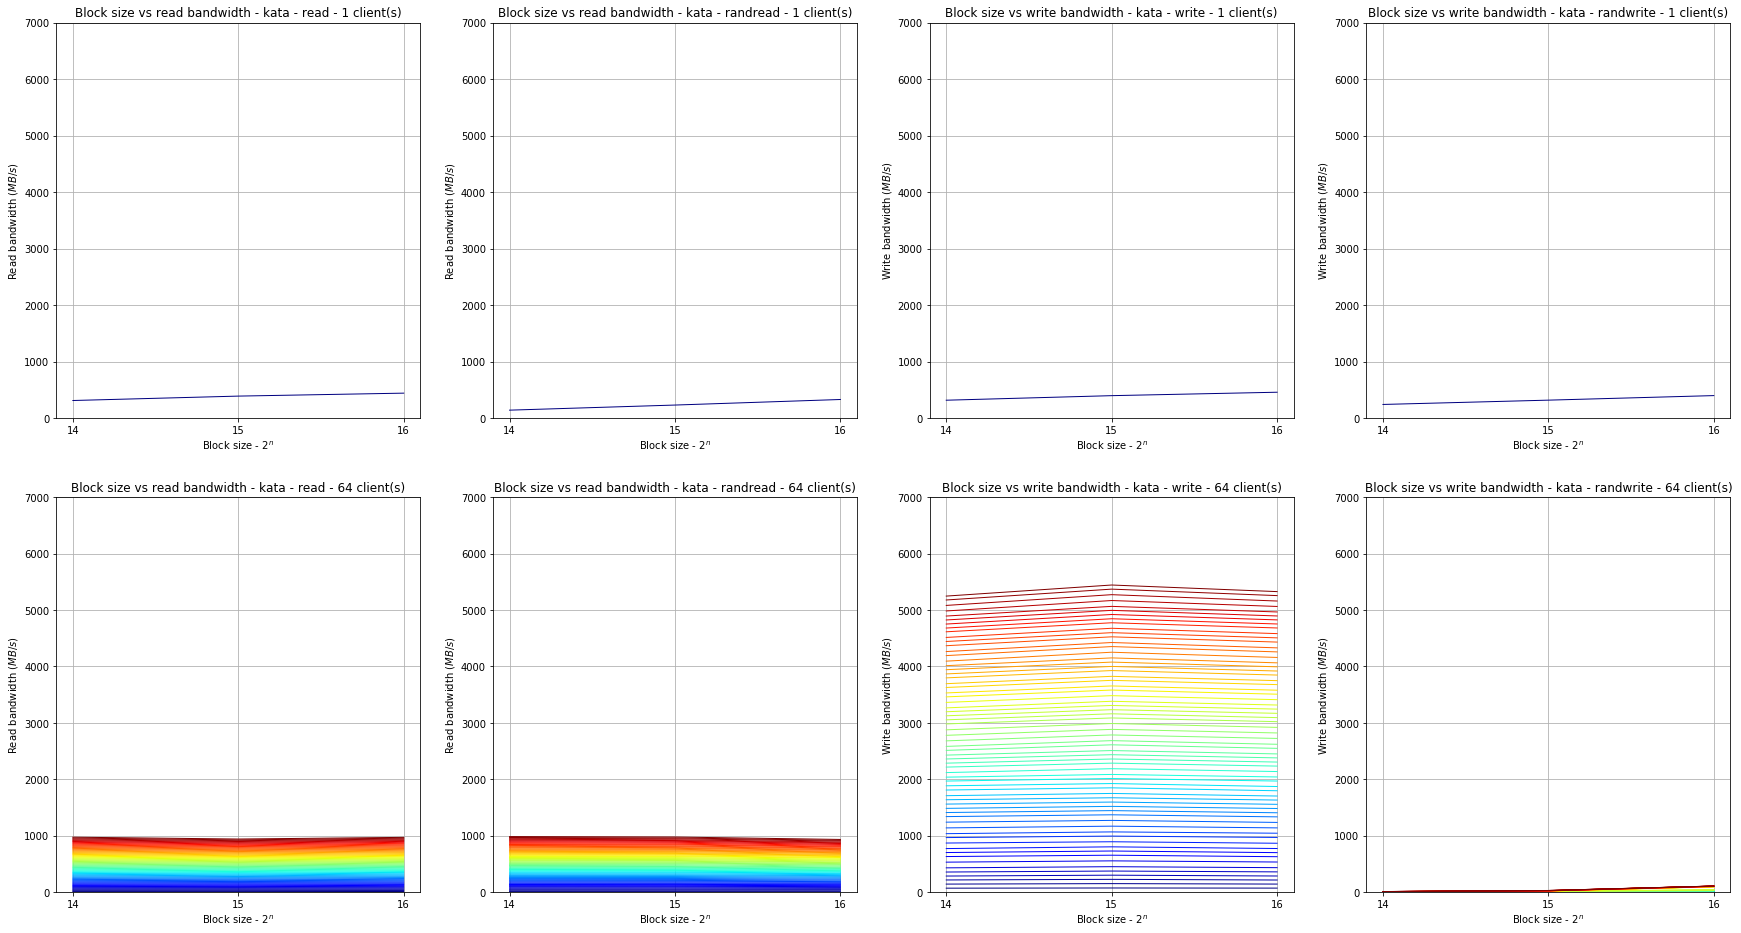

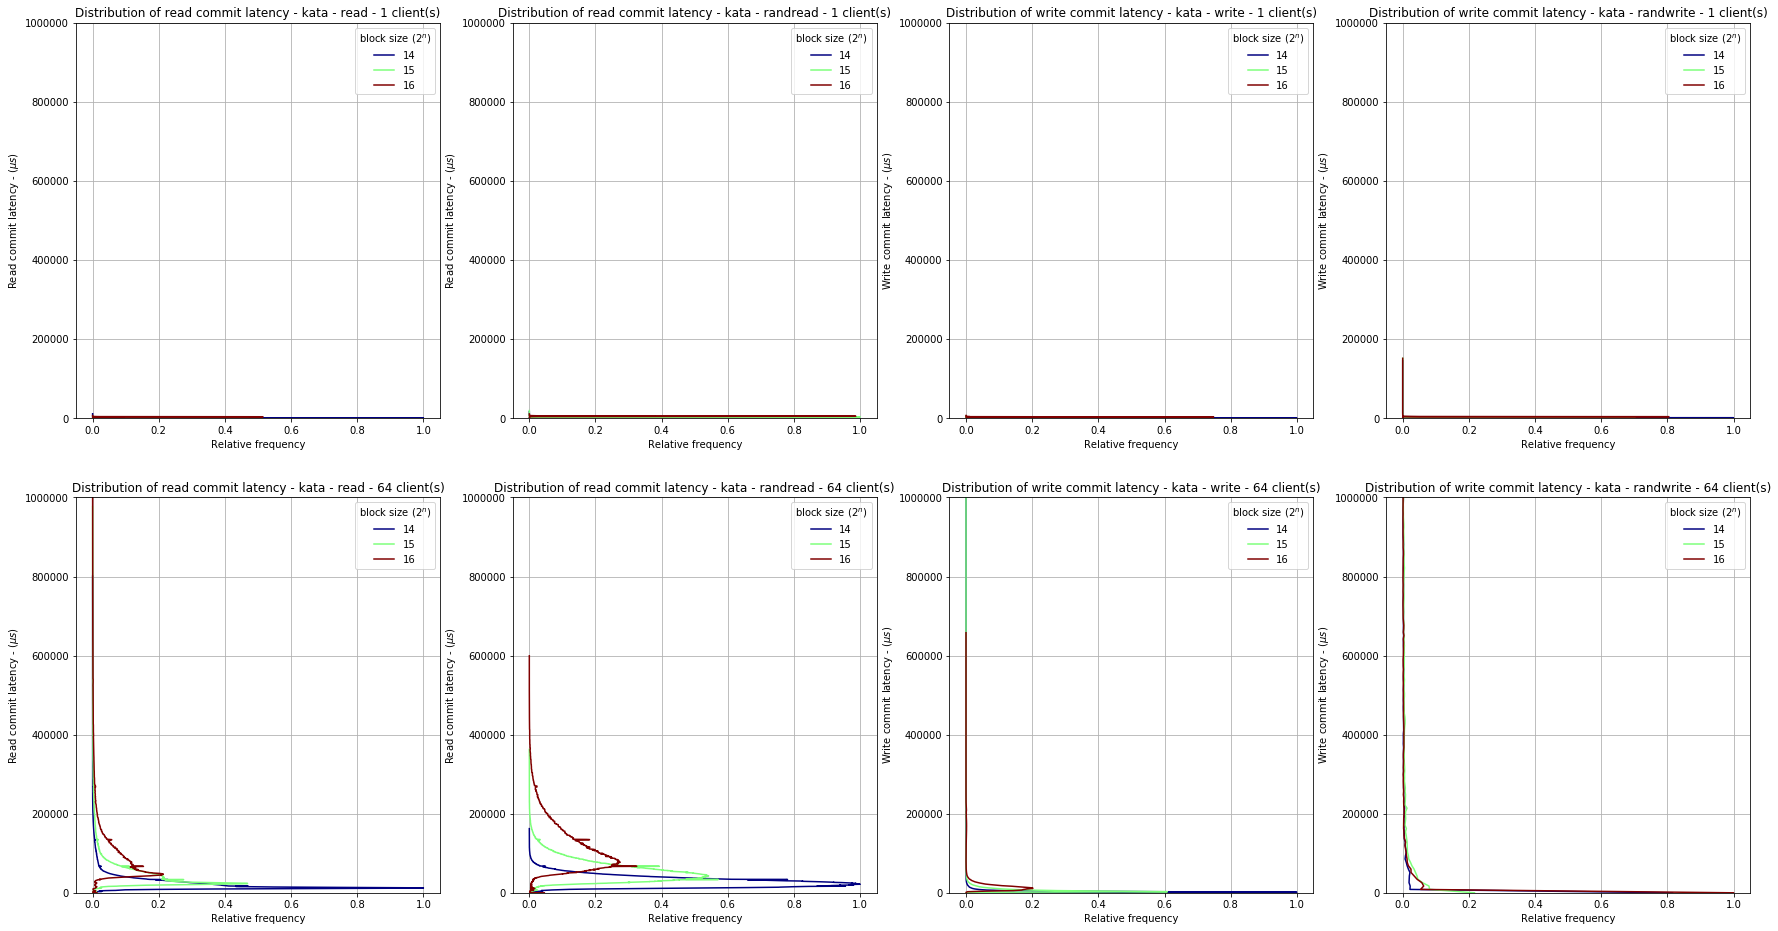

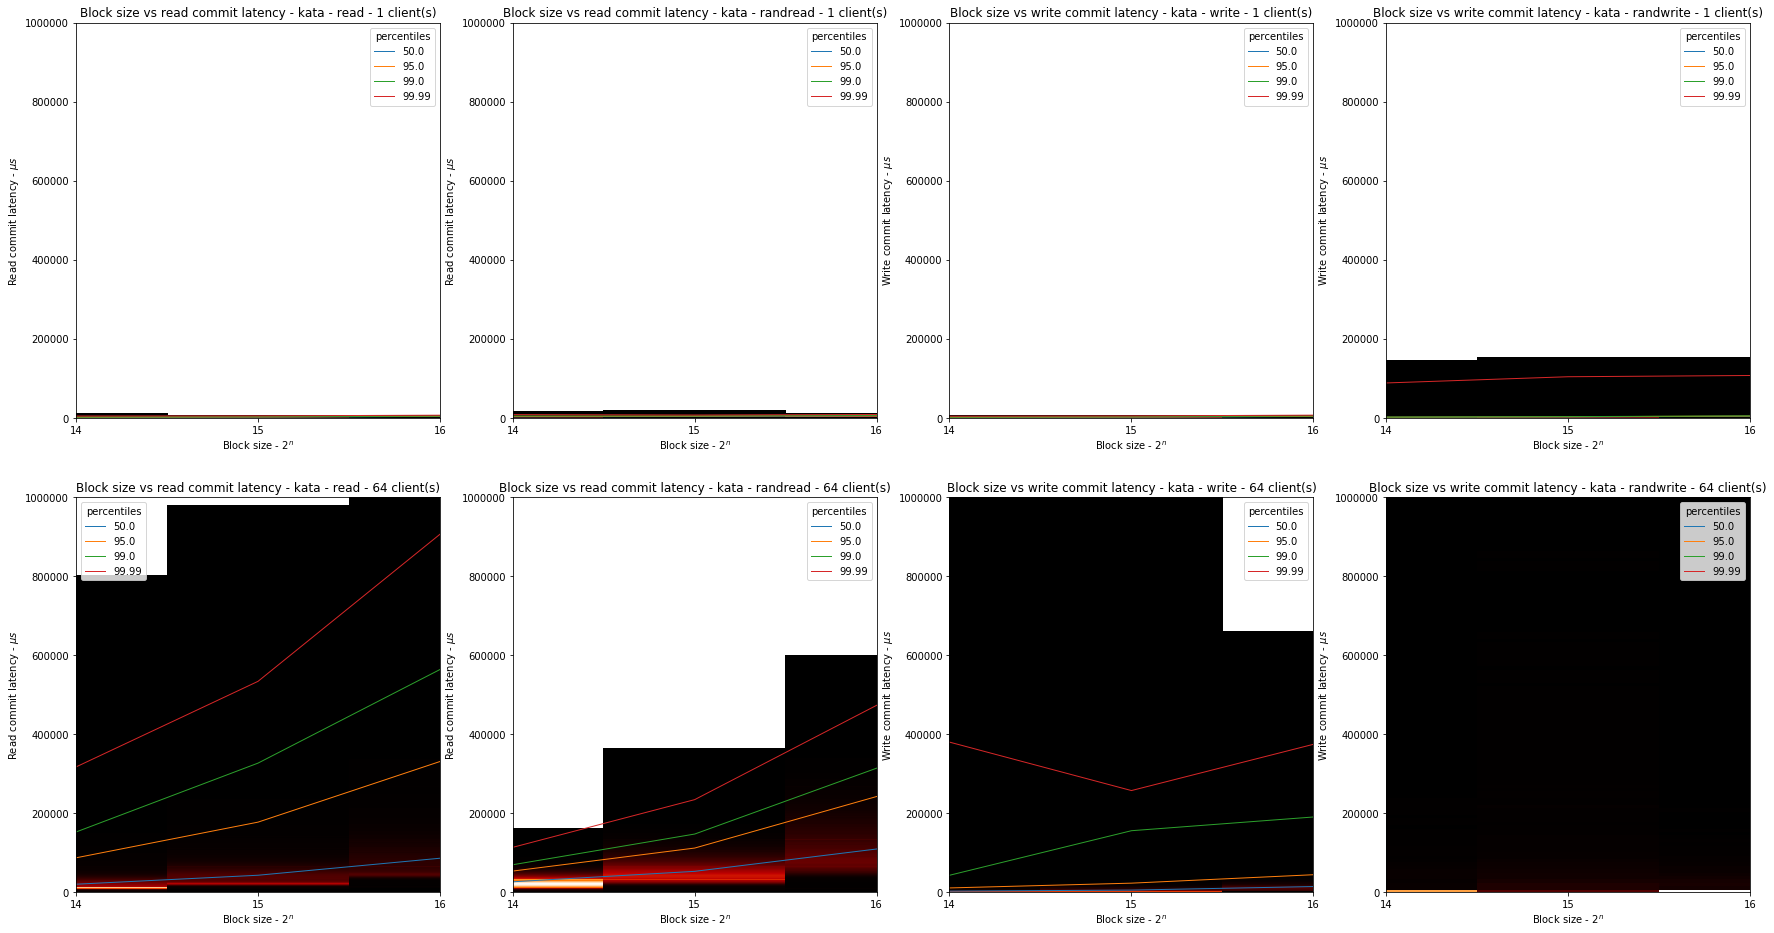

In [161]:
cg = {}
scenarios = ['bare', 'runc', 'kata']
for scenario in scenarios:
    cg[scenario] = clatgrid_helper(scenario)

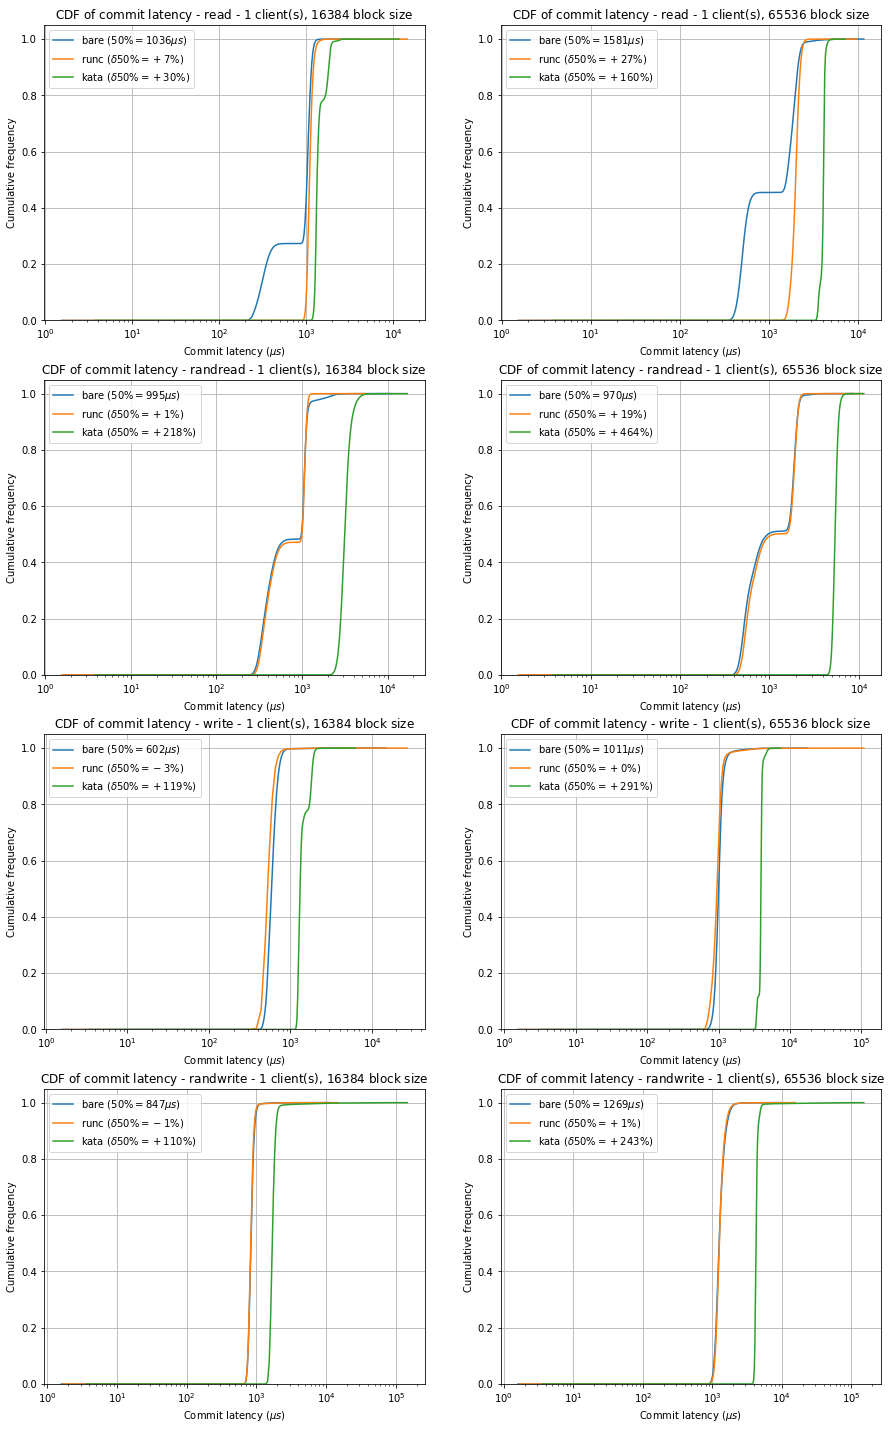

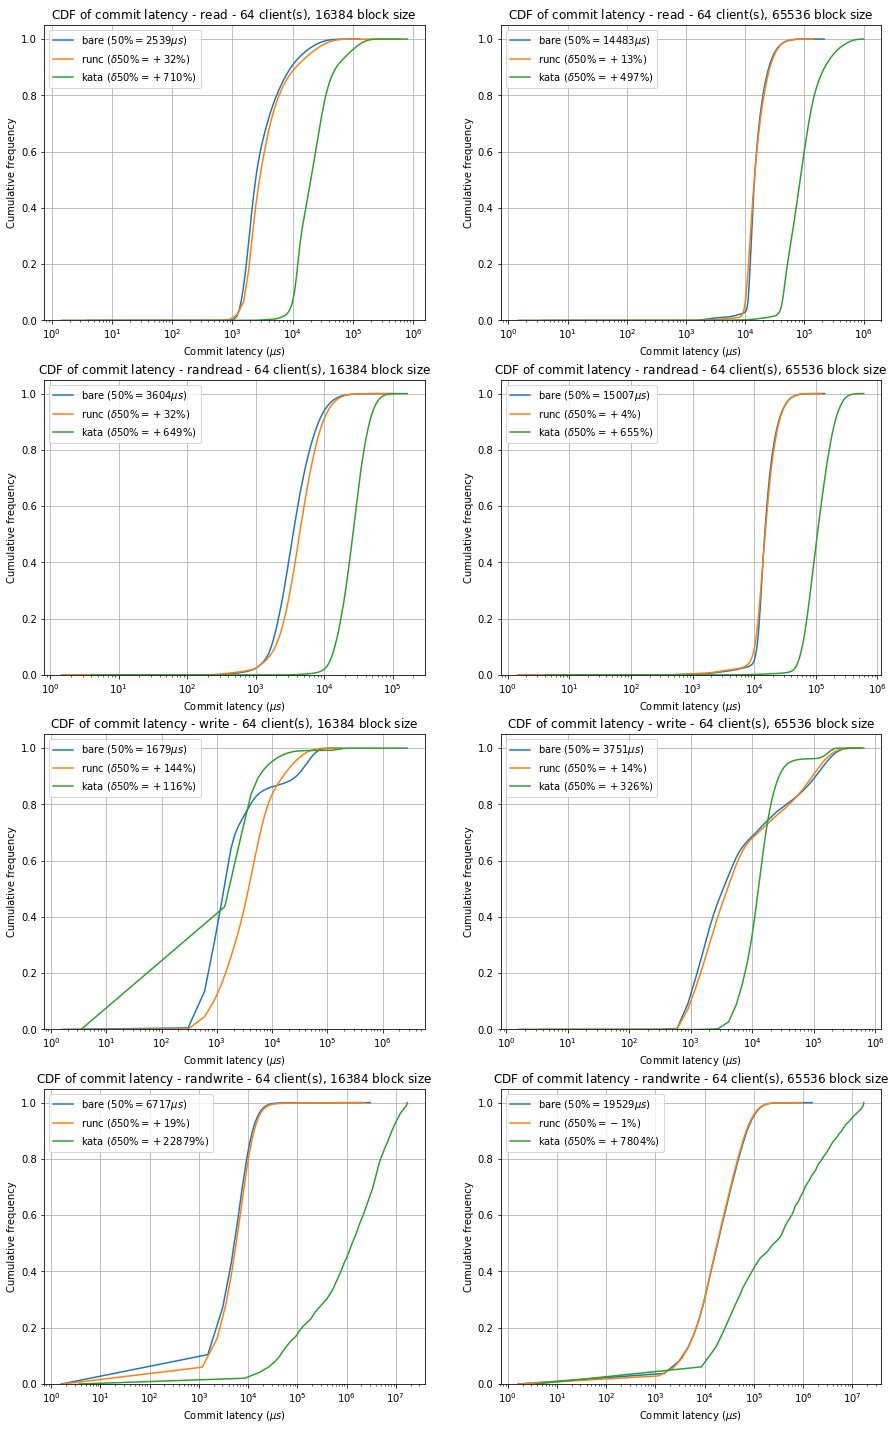

In [183]:
rws = ['read', 'randread', 'write', 'randwrite']
for num_clients in [1, 64]:
    fig, axes = plt.subplots(len(rws), 2, figsize=(15, 25))
    for j, rw in enumerate(rws):
        for i, bs in enumerate([14, 16]):
            ax = axes[j][i]
            median = {}
            for scenario in scenarios:
                this_cg = cg[scenario][num_clients][rw]
                median[scenario] = this_cg.cldf[50.0].groupby(this_cg.cldf.index).mean()[bs]                
                data = this_cg.cfdf[bs].cumsum()
                data -= data.min()
                data /= data.max()
                data.plot(ax=ax, grid=True, logx=True, title='CDF of commit latency - {rw} - ${num_clients}$ client(s), ${bs}$ block size'.format(num_clients=num_clients, rw=rw, bs=2**bs))
            legend = ["{scenario} (${text}$)".format(scenario=s, text="\delta 50\%={}{:0.0f}\%".format('+' if median[s]>=median['bare'] else '', float(median[s]-median['bare'])/median['bare']*100) if s != 'bare' else "50\%={:0.0f} {label}".format(median[s], label=this_cg.ts_label)) for s in scenarios]
            ax.legend(legend)
            ax.set_ylim([0, 1.05])
            ax.set_ylabel('Cumulative frequency')
            ax.set_xlabel('Commit latency (${label}$)'.format(label=this_cg.ts_label))
    fig.savefig('scenario-cumulative-aggregate-cf-{num_clients}-clients'.format(num_clients=num_clients))